# Models for Intrution Detection 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier


**DATA LOADING**
This is from  NSL-KDD Explorations / Tim Goodfellow 

In [2]:
import pandas as pd

# Load dataset (make sure you set the correct path if in Kaggle input folder)
train_df = pd.read_csv("/kaggle/input/nslkdd/KDDTrain+.txt", header=None)
test_df  = pd.read_csv("/kaggle/input/nslkdd/KDDTest+.txt", header=None)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Quick look
train_df.head()


Train shape: (125973, 43)
Test shape: (22544, 43)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


**Creating Colunms for Training** 

In [3]:
# Feature names from NSL-KDD docs
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty_level"
]

train_df.columns = columns
test_df.columns = columns

train_df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


# Labeling Name for Attacks   

In [4]:
# Map attacks to categories
attack_map = {
    'normal': 'normal',
    # DOS
    'neptune': 'dos','smurf': 'dos','back': 'dos','teardrop': 'dos','pod': 'dos','land': 'dos',
    'apache2':'dos','udpstorm':'dos','processtable':'dos','worm':'dos','mailbomb': 'dos',
    # Probe
    'satan':'probe','ipsweep':'probe','nmap':'probe','portsweep':'probe','mscan':'probe','saint':'probe',
    # R2L
    'guess_passwd':'r2l','ftp_write':'r2l','imap':'r2l','phf':'r2l','multihop':'r2l','warezmaster':'r2l',
    'warezclient':'r2l','spy':'r2l','xlock':'r2l','xsnoop':'r2l','snmpguess':'r2l','snmpgetattack':'r2l',
    'httptunnel':'r2l','sendmail':'r2l','named':'r2l',
    # U2R
    'buffer_overflow':'u2r','loadmodule':'u2r','rootkit':'u2r','perl':'u2r','sqlattack':'u2r',
    'xterm':'u2r','ps':'u2r',

}

train_df['attack_category'] = train_df['label'].map(attack_map)
test_df['attack_category']  = test_df['label'].map(attack_map)

train_df[['label','attack_category']].head()


,label,attack_category
0,normal,normal
1,normal,normal
2,neptune,dos
3,normal,normal
4,normal,normal


**Converting Text Data to Numerical Data**

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["protocol_type","service","flag"]

encoder = LabelEncoder()
for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col]  = encoder.transform(test_df[col])


In [6]:
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop(columns=['label','difficulty_level','attack_category'])
X_test  = test_df.drop(columns=['label','difficulty_level','attack_category'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

y_train = train_df['attack_category']
y_test  = test_df['attack_category']


In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train_enc = label_enc.fit_transform(y_train)
y_test_enc  = label_enc.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat  = to_categorical(y_test_enc)

print("Classes:", label_enc.classes_)


2025-09-07 18:20:49.576730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757269249.956796      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757269250.060990      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Classes: ['dos' 'normal' 'probe' 'r2l' 'u2r']


In [9]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
input_dim = X_train.shape[1]
num_classes = y_train_cat.shape[1]

mlp_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()


I0000 00:00:1757269359.613349      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757269359.614104      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,957 (54.52 KB)

 Trainable params: 13,957 (54.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = mlp_model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    verbose=1
)

Epoch 1/20


I0000 00:00:1757269379.785426     102 service.cc:148] XLA service 0x795c3c007840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757269379.786700     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757269379.786719     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757269380.103895     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 68/985 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7532 - loss: 0.8151

I0000 00:00:1757269381.941781     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


985/985 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9331 - loss: 0.2315 - val_accuracy: 0.7576 - val_loss: 1.5003
Epoch 2/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.7544 - val_loss: 1.7950
Epoch 3/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9879 - loss: 0.0409 - val_accuracy: 0.7453 - val_loss: 2.1468
Epoch 4/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9906 - loss: 0.0310 - val_accuracy: 0.7488 - val_loss: 2.0404
Epoch 5/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9902 - loss: 0.0291 - val_accuracy: 0.7485 - val_loss: 2.1941
Epoch 6/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9912 - loss: 0.0263 - val_accuracy: 0.7454 - val_loss: 2.3160
Epoch 7/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.7548 - val_loss: 2.1731
Epoch 8/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9921 - loss: 0.0239 - val_accuracy: 0.7454 - val_

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:

              precision    recall  f1-score   support

         dos       0.95      0.77      0.85      7460
      normal       0.65      0.98      0.78      9711
       probe       0.83      0.60      0.70      2421
         r2l       0.91      0.01      0.02      2885
         u2r       0.78      0.31      0.45        67

    accuracy                           0.74     22544
   macro avg       0.82      0.53      0.56     22544
weighted avg       0.80      0.74      0.70     22544



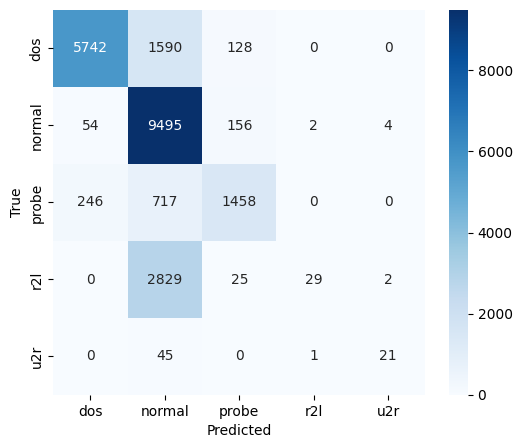

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = mlp_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_enc.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
